In [77]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI.ipynb")

# Final Project: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Thursday, December 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [79]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_wind,daily_WIND_2020
7,daily_temp,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [80]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name):
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [81]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

_The data likely contains outliers of AQI far greater/less than the majority of the data, so the maximum AQI could be an outlier and thus mislead us on what the data looks like. The 90th percentile AQI is a safer estimation of the upper bound of the non-outlier data. When the difference between the 90th percentile AQI and the Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI, it means the Max AQI is likely an outlier._

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [82]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.to_datetime(daily_county["Date"]).dt.month
daily_county['Day'] = pd.to_datetime(daily_county["Date"]).dt.day


daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [83]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [84]:
epa_daily = {}
for (key, value) in epa_data.items():
    if "daily" in key:
        epa_daily[key] = value

epa_data_CA = {}
for (key, value) in epa_daily.items():
    if "State Name" in value:
        cond1 = value["State Name"] == "California"
        epa_data_CA[key] = (epa_daily[key].loc[cond1])
    if "State" in value:
        cond2 = value["State"] == "California"
        epa_data_CA[key] = (epa_daily[key].loc[cond2])
    

epa_data_CA.get('daily_county_aqi').head()


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [85]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [86]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
county_aqi = epa_data_CA.get("daily_county_aqi")
aqi_sites = epa_data.get('aqs_sites')

# Reformat County and Site numbers to Site ID format
aqi_sites['County Code'] = aqi_sites['County Code'].astype(str)
aqi_sites['Site Number'] = aqi_sites['Site Number'].astype(str)
aqi_sites['County Code'] = aqi_sites['County Code'].str.pad(width=3, side='left', fillchar='0')
aqi_sites['Site Number'] = aqi_sites['Site Number'].str.pad(width=4, side='left', fillchar='0')

# Add Defining Site column to aqi_sites for join
aqi_sites['Defining Site'] = aqi_sites['State Code'] + "-" + aqi_sites['County Code'] + "-" + aqi_sites['Site Number']

# Join daily_county_aqi with aqi_sites on Defining Site to obtain latitude & longitude
cleaned_county_aqi = county_aqi[['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site']]
cleaned_aqi_sites = aqi_sites[['Defining Site', 'Latitude', 'Longitude']]
epa_data_CA_merged = cleaned_county_aqi.merge(cleaned_aqi_sites.set_index('Defining Site'), on='Defining Site', how='left')


epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217


In [87]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [88]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
traffic_data = traffic_data[['District', 'Route', 'County', 'Descriptn', 'Back_AADT', 'Ahead_AADT', 'Lon_S_or_W',
       'Lat_S_or_W', 'Lon_N_or_E', 'Lat_N_or_E']]

# Replace empty spaces in AADT columns with 0
traffic_data['Back_AADT'] = traffic_data['Back_AADT'].str.replace(' ', '0')
traffic_data['Ahead_AADT'] = traffic_data['Ahead_AADT'].str.replace(' ', '0')

# Create new combined AADT column & drop back and ahead AADT
traffic_data['AADT'] = traffic_data['Back_AADT'].astype(int) + traffic_data['Ahead_AADT'].astype(int)
traffic_data = traffic_data.drop(columns=['Back_AADT', 'Ahead_AADT'])

# Drop all rows with strings from latitude & longitude
traffic_data['Lon_S_or_W'] = traffic_data['Lon_S_or_W'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
ind1 = traffic_data['Lon_S_or_W'].isna()
traffic_data = traffic_data.drop(traffic_data[ind1].index)
traffic_data['Lat_S_or_W'] = traffic_data['Lat_S_or_W'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
ind2 = traffic_data['Lat_S_or_W'].isna()
traffic_data = traffic_data.drop(traffic_data[ind2].index)
traffic_data['Lat_N_or_E'] = traffic_data['Lat_N_or_E'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
ind3 = traffic_data['Lat_N_or_E'].isna()
traffic_data = traffic_data.drop(traffic_data[ind3].index)
traffic_data['Lon_N_or_E'] = traffic_data['Lon_N_or_E'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
ind4 = traffic_data['Lon_N_or_E'].isna()
traffic_data_cleaned = traffic_data.drop(traffic_data[ind4].index)

traffic_data_cleaned.head()


,District,Route,County,Descriptn,Lon_S_or_W,Lat_S_or_W,Lon_N_or_E,Lat_N_or_E,AADT
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,-123.518503,38.759843,-123.518503,38.759843,4000
1,1,1,MEN,NORTH LIMITS GUALALA,-123.531890,38.770046,-123.531890,38.770046,7100
2,1,1,MEN,FISH ROCK ROAD,-123.585411,38.803549,-123.585411,38.803549,6200
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",-123.691513,38.903973,-123.691513,38.903973,4600
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",-123.692410,38.910913,-123.692410,38.910913,5000


In [89]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [90]:
# Create gpd df's
geo_traffic = gpd.GeoDataFrame(
    traffic_data_cleaned, geometry=gpd.points_from_xy(traffic_data_cleaned.Lon_S_or_W, traffic_data_cleaned.Lat_S_or_W))
epa_data_CA_merged_copy = epa_data_CA_merged.copy()
geo_epa = gpd.GeoDataFrame(
    epa_data_CA_merged_copy, geometry=gpd.points_from_xy(epa_data_CA_merged_copy.Longitude, epa_data_CA_merged_copy.Latitude))

# sjoin_nearest epa and traffic
gpd_epa_traffic = gpd.sjoin_nearest(geo_epa, geo_traffic, how = "left")
traffic_aadt = gpd_epa_traffic.copy()

# Clean
gpd_epa_traffic = gpd_epa_traffic.rename(columns = {"Lat_S_or_W": "Traffic Lat", "Lon_S_or_W": "Traffic Long", "Latitude": "Site Lat", "Longitude": "Site Long"})
gpd_epa_traffic = gpd_epa_traffic[["State Name", "county Name", "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", "Traffic Lat", "Traffic Long", "Descriptn"]]

gpd_epa_traffic.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE"
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741,37.866594,-122.303832,"BERKELEY, UNIVERSITY AVENUE"
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741,37.866594,-122.303832,"BERKELEY, UNIVERSITY AVENUE"
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217,37.700835,-121.773562,NORTH LIVERMORE AVENUE
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217,37.700835,-121.773562,NORTH LIVERMORE AVENUE


In [91]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [92]:
aqis = epa_data.get('annual_county_aqi') #loading the table 
american_aqis = aqis[~aqis["State"].isin({"Country Of Mexico","District Of Columbia", "Virgin Islands","Puerto Rico"})] #filtering out non-American states
grouped_by_state_mean = american_aqis.groupby(["State"]).mean() #grouping by mean

worst_median_aqis = grouped_by_state_mean.sort_values(by = "Median AQI", ascending = False)["Median AQI"][:10]
worst_max_aqis = grouped_by_state_mean.sort_values(by = "Max AQI", ascending = False)["Max AQI"][:10]

worst_median_aqis.name = "Average Median AQI"
worst_max_aqis.name = "Average Max AQI"

print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

np.round(list(worst_max_aqis), 2)

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Average Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Average Max AQI, dtype: float64


array([430.35, 334.42, 286.98, 238.23, 197.86, 196.67, 196.67, 137.42,
       133.  , 124.75])

In [93]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

_California, Arizona, Nevada, and Connecticut appear in both top 10 lists. In regards to California, Arizona, and Nevada, I think a large part of why they appear on both lists is due to both of them being very prone to wildfire. Almost every summer/fall, all 3 of these states suffer catastrophic wildfire seasons that undoubtedly ruin the AQI due to ash, smoke, and other combusted organic material. Furthermore, these 3 states are also relatively extremely drought ridden, and suffer from lack of precipitation, which could also further contribute to worse AQIs.
._

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [94]:
days_with_AQI = grouped_by_state_mean.sort_values(by = "Days with AQI", ascending = True)["Days with AQI"]

days_with_AQI.head()

State
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [95]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [96]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [97]:
counties = set(ca_annual_data["County"])

daily_county_aqi = epa_data.get('daily_county_aqi')
daily_county_aqi_california = daily_county_aqi[daily_county_aqi["State Name"] == "California"]
group_by_dates = daily_county_aqi_california.groupby(["Date"]).agg(set)["county Name"]
group_by_dates #dates and counties that have data for that date

missing_date_freqs= {}
county_to_missing_dates = {}
dates = group_by_dates.index
for i in range(len(group_by_dates)):
    d = dates[i]
    missing = counties - group_by_dates[i]
    for county in missing:
        county_to_missing_dates[county] = county_to_missing_dates.get(county,[]) + [d]
        missing_date_freqs[d] = missing_date_freqs.get(d,0) + 1
county_to_missing_dates

{'Amador': ['2020-01-04',
  '2020-01-05',
  '2020-01-06',
  '2020-01-07',
  '2020-08-24',
  '2020-10-17',
  '2020-10-18'],
 'Plumas': ['2020-01-06',
  '2020-02-16',
  '2020-02-25',
  '2020-02-26',
  '2020-02-28',
  '2020-02-29'],
 'Tuolumne': ['2020-01-08',
  '2020-01-26',
  '2020-01-27',
  '2020-01-28',
  '2020-01-29',
  '2020-01-30',
  '2020-01-31',
  '2020-02-01',
  '2020-02-02',
  '2020-02-03',
  '2020-09-07',
  '2020-09-08',
  '2020-10-25'],
 'Del Norte': ['2020-01-15',
  '2020-01-16',
  '2020-01-17',
  '2020-01-18',
  '2020-01-20',
  '2020-01-21',
  '2020-01-23',
  '2020-03-14',
  '2020-03-15',
  '2020-04-22',
  '2020-04-23',
  '2020-04-25',
  '2020-04-26',
  '2020-04-28',
  '2020-04-29',
  '2020-05-01',
  '2020-05-02',
  '2020-05-04',
  '2020-05-05',
  '2020-05-07',
  '2020-05-08',
  '2020-05-10',
  '2020-05-11',
  '2020-05-13',
  '2020-05-14',
  '2020-05-16',
  '2020-05-17',
  '2020-05-19',
  '2020-05-20',
  '2020-05-22',
  '2020-05-23',
  '2020-05-25',
  '2020-05-26',
  '2020-

In [98]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

_Yes, February 29th (leap day) is missing by 3 different counties. Del Norte and Trinity counties have the most missing days and I believe this could be due to the counties being extremely isolated, remote,  and sparse in population, which may lead to lack of attention and overhead going into the recording of data (and reliability of methods) since this data originates from such a low populated area (and therefore holds less priority and demands less monitoring)._


<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [99]:
aqi_per_month = daily_county.groupby("Month").mean()['AQI']
aqi_per_month_CA = epa_data_CA.get('daily_county_aqi').groupby("Month").mean()['AQI']


print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [100]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

_The average aqi per month in California is consistently higher than the country's average, with a large peak in August, September (the highest at 107), and October. One reason for this is that California is the most populated state, which means increased its economy, businesses, and transportation produce greater pollution than other states that would be less densely populated. Also, as mentioned before, California is prone to wildfires, whose smoke travels far throughout the state and degrades the overall air quality, especially during the dry summer months._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

_If the average AQI was the same every year, then a good model to represent the pattern could be a modified sine function to capture the repeating peaks every month, f(x) = sin(x) + c. Or if the AQI every month has very little change, a constant function where f(x) = c might fit well. If we see a linear increase in the average AQI instead, then we can use a linear model to fit the data, where g(x) = mx + c, or a combination of a sine and linear function, g(x) = k*sin(x) + mx + c._

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [101]:
def bucket_data(table, aggfunc, resolution):
    table_copy = table.copy()
    long_buckets = np.sort(np.linspace(table_copy['Longitude'].min(), table_copy['Longitude'].max(), num = resolution, endpoint = False))
    lat_buckets = np.sort(np.linspace(table_copy['Latitude'].min(), table_copy['Latitude'].max(), num = resolution, endpoint = False))
    
    long_buckets_map = dict(list(zip(long_buckets, np.around(long_buckets, decimals = 2))))
    lat_buckets_map = dict(list(zip(lat_buckets, np.around(lat_buckets, decimals = 2))))
    
    get_lat_bucket_num = lambda loc : lat_buckets_map.get(lat_buckets[lat_buckets <= loc].max())
    get_long_bucket_num = lambda loc : long_buckets_map.get(long_buckets[long_buckets <= loc].max())
    
    table_copy['lat_bucket'] = table_copy['Latitude'].apply(get_lat_bucket_num)
    table_copy['long_bucket'] = table_copy['Longitude'].apply(get_long_bucket_num)
    
    pivot_cols = ['lat_bucket', 'long_bucket', 'AQI']
    return pd.pivot_table(table_copy[pivot_cols], index = 'lat_bucket', columns = 'long_bucket', aggfunc = aggfunc)

bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket    -124.20    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

In [102]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

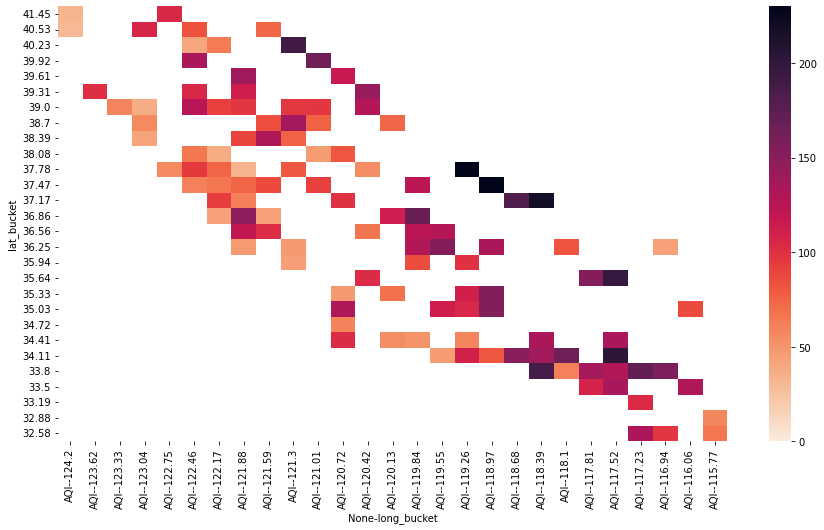

In [103]:
temp_ca = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(temp_ca, np.median, 30)

#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [104]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

_As the heatmap is based on longitude and latitude of data from California, the resulting graph becomes a crude map of California itself, following its diagonal shape. It makes sense as the darker concentrated regions in the heat map correspond to highly populated areas, areas covered in wildfire last year, or both like the Los Angeles area. We can also see a slight gradient in air quality as we go south, which could be due to population and climate._


<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [105]:
cleaned_county_aqi

,State Name,county Name,Month,Day,AQI,Category,Defining Site
14003,California,Alameda,1,1,53,Moderate,06-001-0009
14004,California,Alameda,1,2,43,Good,06-001-0013
14005,California,Alameda,1,3,74,Moderate,06-001-0013
14006,California,Alameda,1,4,45,Good,06-001-0007
14007,California,Alameda,1,5,33,Good,06-001-0007
...,...,...,...,...,...,...,...
33223,California,Yolo,12,27,20,Good,06-113-0004
33224,California,Yolo,12,28,33,Good,06-113-0004
33225,California,Yolo,12,29,28,Good,06-113-0004
33226,California,Yolo,12,30,39,Good,06-113-0004


In [106]:
# Looking at race and AQI across counties in CA
# Create new cleaned AQI table grouped by county
stats_county_aqi = cleaned_county_aqi.groupby("county Name").median().drop(["Month", "Day"], axis=1)
top90_aqi = cleaned_county_aqi.groupby("county Name").quantile(0.9).drop(["Month", "Day"], axis=1)
min_aqi = cleaned_county_aqi.groupby("county Name").min().drop(["Month", "Day"], axis=1)

stats_county_aqi["90th Percentile AQI"] = top90_aqi["AQI"]
stats_county_aqi["Min AQI"] = min_aqi["AQI"]
stats_county_aqi = stats_county_aqi.rename(columns={"AQI": "Median AQI"})

# Reading in table of race demographics by county in CA
ca_race = pd.read_excel('data/CA2020_race.xlsx')
ca_race = ca_race.rename(columns={'Label': 'county Name'}).iloc[2:7]
ca_race = ca_race.set_index("county Name").transpose()

# Clean ca_race data
ca_race = ca_race.replace(',','', regex=True)
ca_race = ca_race.apply(pd.to_numeric)

# Convert population numbers into proportions
prop_ca_race = ca_race.div(ca_race.sum(axis=1), axis=0)
prop_ca_race = prop_ca_race.reset_index()
prop_ca_race = prop_ca_race.rename(columns={'index': 'county Name'})
prop_ca_race
prop_ca_race['county Name'] = prop_ca_race['county Name'].str.extract(r'(.*) County,')

stats_county_aqi = stats_county_aqi.reset_index()
stats_county_aqi = stats_county_aqi.rename(columns={'index': 'county Name'})
# Joined race and AQI tables
joint_race_aqi = stats_county_aqi.merge(prop_ca_race, how = 'left', on = "county Name").sort_values(by="Black or African American alone", ascending=False)
joint_race_aqi.head()


,county Name,Median AQI,90th Percentile AQI,Min AQI,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone
43,Solano,41.0,75.0,19,0.548862,0.194094,0.016825,0.227223,0.012996
32,San Bernardino,93.0,185.0,36,0.652972,0.153970,0.034758,0.152076,0.006224
16,Los Angeles,83.0,164.0,28,0.567670,0.138348,0.028469,0.261241,0.004271
0,Alameda,43.0,79.0,20,0.413199,0.130056,0.015507,0.430099,0.011140
30,Sacramento,51.5,100.0,26,0.602561,0.128637,0.015690,0.237189,0.015924


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

r for Black Prop v. AQI is: 0.5365355787129255


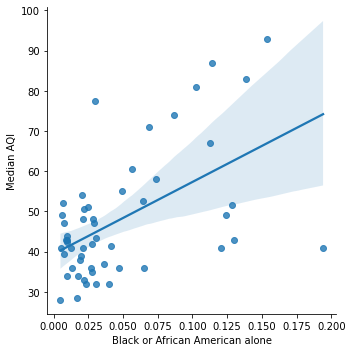

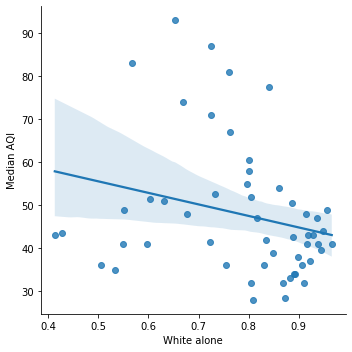

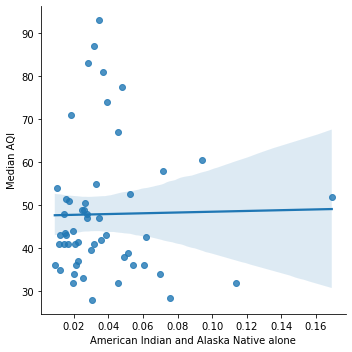

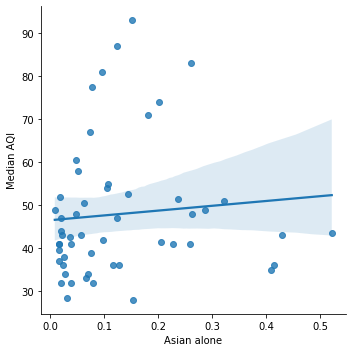

In [107]:
# several lmplots across race
race_aqi_lm = sns.lmplot(x="Black or African American alone", y="Median AQI", data=joint_race_aqi);
print("r for Black Prop v. AQI is: " + str(np.corrcoef(joint_race_aqi['Black or African American alone'], joint_race_aqi['Median AQI'])[0,1]))
race_aqi_lm = sns.lmplot(x="White alone", y="Median AQI", data=joint_race_aqi);
race_aqi_lm = sns.lmplot(x="American Indian and Alaska Native alone", y="Median AQI", data=joint_race_aqi);
race_aqi_lm = sns.lmplot(x="Asian alone", y="Median AQI", data=joint_race_aqi);

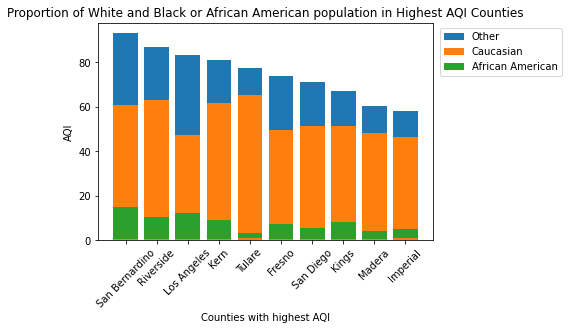

In [108]:
ten_highest = joint_race_aqi.sort_values(by = ['Median AQI'], ascending = False).head(10)
plt.bar(ten_highest['county Name'], ten_highest['Median AQI'])
plt.bar(ten_highest['county Name'], ten_highest['White alone'] * ten_highest['Median AQI'])
ax = plt.bar(ten_highest['county Name'], ten_highest['Black or African American alone'] * ten_highest['Median AQI'], bottom = ten_highest['White alone'])
plt.xticks(rotation = 45)
plt.title("Proportion of White and Black or African American population in Highest AQI Counties")
plt.xlabel("Counties with highest AQI")
plt.ylabel("AQI")
plt.legend(labels = ['Other','Caucasian','African American'], bbox_to_anchor=(1.4, 1));

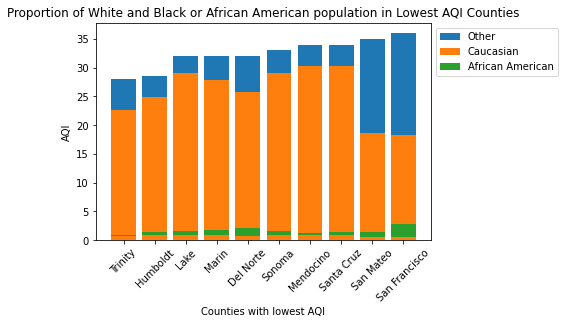

In [109]:
ten_lowest = joint_race_aqi.sort_values(by = ['Median AQI']).head(10)
plt.bar(ten_lowest['county Name'], ten_lowest['Median AQI'])
plt.bar(ten_lowest['county Name'], ten_lowest['White alone'] * ten_lowest['Median AQI'])
plt.bar(ten_lowest['county Name'], ten_lowest['Black or African American alone'] * ten_lowest['Median AQI'], bottom = ten_lowest['White alone'])
plt.xticks(rotation = 45)
plt.title("Proportion of White and Black or African American population in Lowest AQI Counties")
plt.xlabel("Counties with lowest AQI")
plt.ylabel("AQI")
plt.legend(labels = ['Other','Caucasian','African American'], bbox_to_anchor=(1, 1));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

_Due to California's history of redlining and other racially discriminatory acts/policies, we wanted to look at how demography relates to AQI, focusing on BIPOC vs White populations' relationships to AQI. First we looked at the relationship between individual racial proportions and median AQI using lmplots. We can see a positive correlation between the proportion of Black or African Americans in the county versus AQI, whereas the proportion of Whites had a negative correlation with AQI. Asians and American Indian/Alaska Native do not seem to show any correlation with AQI._


_To compare the two groups with correlation against each other, we used a stacked bar plot where the Black proportion shows as green, the White proportion as orange, and the total AQI shows as blue. By comparing the 10 counties of the highest and lowest AQIs, we can see that the highest AQI counties have a greater proportion of Blacks or African Americans versus Whites than the lowest AQI counties._


<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

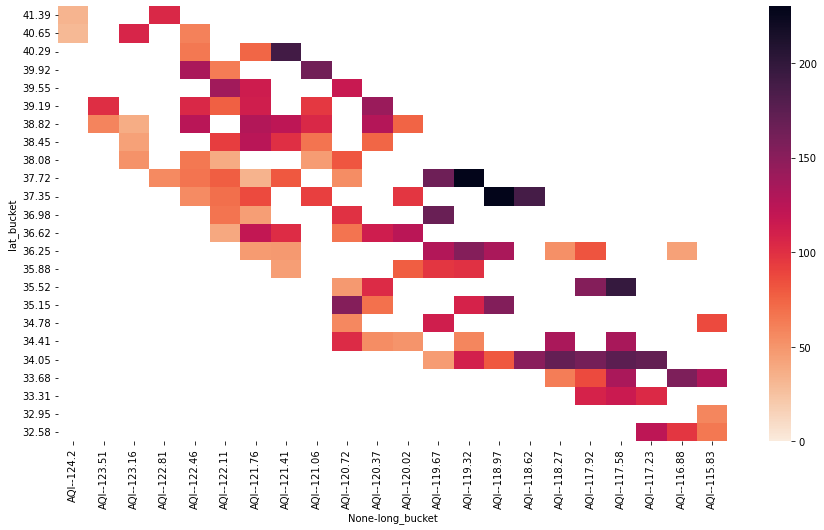

In [110]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [111]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    valid = 0
    prox_values = []
    
    if not np.isnan(pivot_table.iloc[lat_bucket, lon_bucket]):
        return pivot_table.iloc[lat_bucket, lon_bucket]
    else:
        # checks left
        if not np.isnan(pivot_table.iloc[lat_bucket, :lon_bucket]).all():
            valid += 1
            for x in pivot_table.iloc[lat_bucket, :lon_bucket].sort_index(ascending=False):
                if not np.isnan(x):
                    prox_values.append(x)
                    break
                    
        # checks right
        if not np.isnan(pivot_table.iloc[lat_bucket, (lon_bucket + 1):]).all():
            valid += 1         
            for x in pivot_table.iloc[lat_bucket, (lon_bucket + 1):]:
                if not np.isnan(x):
                    prox_values.append(x) 
                    break
         
        # checks below
        if not np.isnan(pivot_table.iloc[:lat_bucket, lon_bucket]).all():
            valid += 1 
            for x in pivot_table.iloc[:lat_bucket, lon_bucket].sort_index(ascending=False):
                if not np.isnan(x):
                    prox_values.append(x)
                    break
        
        # checks above
        if not np.isnan(pivot_table.iloc[(lat_bucket + 1):, lon_bucket]).all():
            valid += 1
            for x in pivot_table.iloc[(lat_bucket + 1):, lon_bucket]:
                if not np.isnan(x):
                    prox_values.append(x)  
                    break
    if valid >= 3:
        return np.mean(prox_values)
    else:
        return np.nan


In [112]:
grader.check("q8a")

q8a results: All test cases passed!

def fill_all(pivot_table):
    pivot_table_copy = pivot_table
    rows = pivot_table.shape[1] 
    columns = pivot_table.shape[0] 
    for i in np.arange(columns):
        for j in np.arange(rows):
            pivot_table_copy.iloc[i,j] = fill_bucket(pivot_table, i, j)
    return pivot_table_copy

filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()   
<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

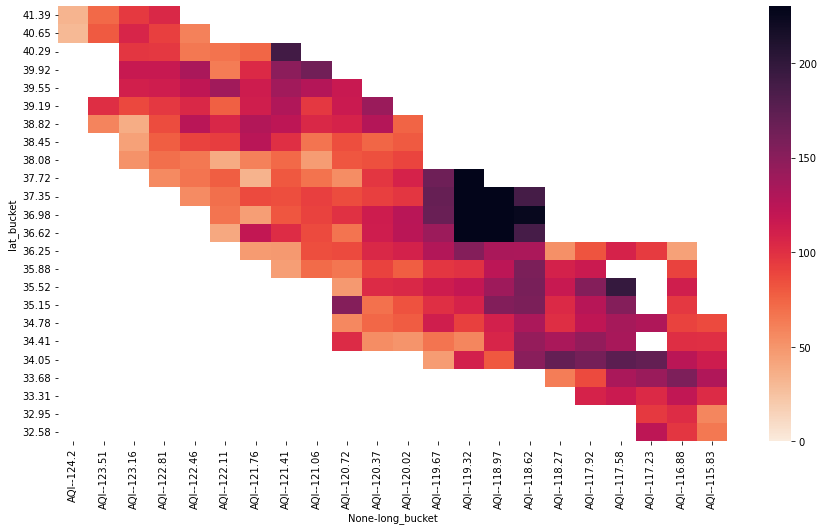

In [113]:
def fill_all(pivot_table):
    pivot_table_copy = pivot_table
    rows = pivot_table.shape[1] 
    columns = pivot_table.shape[0] 
    for i in np.arange(columns):
        for j in np.arange(rows):
            pivot_table_copy.iloc[i,j] = fill_bucket(pivot_table, i, j)
    return pivot_table_copy

filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()   


In [114]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

_Another interpolation method would be to scale the value of the Above, Below, Right, and Left value by distance. As such we can utilize the same method we used in 8a but take into account distance. For instance, if the NaN cell has a value above it (meaning that there are no additional empty spaces from the NaN cell to a non-NaN cell), we can use that value itself without scaling by any factor. However, if for that same NaN cell, there is a non-NaN value 4 spaces to the right, we can scale that value by 0.1 * number of NaN cells (or any other value to represent the distance), decreasing the weight of that cell on our interpolated value._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

_I would design my loss function to determine how far the model's estimated output $\hat{y}$ differs from the actual $y_i$. Since the categorical variable of the 6 AQI groups are of different magnitude/extremety, using an absolute value function could be useful to take into account how large the error in estimation is. For example, for a given $i$, let's say $x_i$ yields  $\hat{y_i} =$ unhealthy for sensitive groups. If $y_i$ is $good$, the loss function would yield a greater loss for $\hat{y_i} =$ $unhealthy for sensitive groups$ than if $y_i=$ $moderate$. The loss function would output 0 loss if $\hat{y_i} = y_i$. If we utilize this absolute value, the summed value over all $i$ may be too large so I would take the mean of the absolute values as my loss function._

<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

_The features that we will be using for our model are region (determined by the county), average AADT (Average Annual Daily Traffic by county), total population (by county), average population density (by county), season (determined by month), ozone level (by parts per million), latitude/longitude, and elevation. (AADT comes from the included traffic dataset; Total population and Average Population Density from external dataset sourced from U.S. Census, the external dataset features are commented out for atuograder) I think that ozone level will be very predictive of the AQI category since air particulate matter is very correlated with AQI. Additionally, I think that population density will be fairly predictive of AQI category since higher density would correlate to higher use of resources such as gas for transportation. We also chose season as a feature because we believe that seasons like Summer and Spring are more prone to wildfires meaning that AQI during these time frames may be higher. As for latitude/longitude, we think it will be less predictive of AQI but we wanted to include it because it is a quantitative variable versus the categorical variable of region. Finally, we think that elevation will be fairly predictive of AQI category since elevation may be related with other variables like wind speed (which affects AQI)._

_We will choose to make our multiple regression model by first conducting a train-test split on our cleaned data-set of CA dataset. Then we will utilize a feature function to create a design matrix from the training set by utilizing OHE/dummies for categorical variables and standardizing numerical variables appropriately. Once we create a design matrix, we will utilize our build_model function to create a model and fit our model to our training data (design matrix and targets). Then we will test our model by first predicting AQI using our test-data as an input into our model fitted on training data and utilizing the loss function that we described above to determine whether our model is effective._


<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

In [115]:
# External county population dataset (will be commented out for submission) (EXTERNAL DATASET)
# url = 'https://raw.githubusercontent.com/takeonm/data100_external_datasets/main/county_pops.csv'
# external_cpop = pd.read_csv(url)
# external_cpop = external_cpop.drop(columns = ["GrowthRate"])
# county_remover = lambda s: s[:-7] 
# external_cpop["County"] = external_cpop["County"].apply(county_remover) #removing "County" from the end of each name
# external_cpop = external_cpop.rename(columns={"County": "county Name", "pop2021": "Total Population", "popDensity": "Population Density"})
# external_cpop['Total Population'] = external_cpop['Total Population'].astype(int)
# external_cpop['Population Density'] = external_cpop['Population Density'].astype(float)
# display(external_cpop.head())

# Cleaning data
# Match CA counties to regions (EXTERNAL DATASET)
# ca_regions = pd.read_excel('data/ca_regions.xlsx')
# regions_pop_density = ca_regions.merge(external_cpop, on= 'county Name', how="left")
# regions_pop_density = regions_pop_density.set_index('county Name')

# Cleaning data

# Match CA counties to regions (EXTERNAL DATA SET)
# ca_regions = pd.read_excel('data/ca_regions.xlsx')
# regions_pop_density = ca_regions.set_index('county Name')

# Adding Traffic AADT
traffic_aadt = traffic_aadt[['county Name', 'AADT']]
traffic_aadt = traffic_aadt.rename(columns = {"county Name": "County Name"})
traffic_aadt = traffic_aadt.groupby(by = "County Name").mean().round()
traffic_aadt['AADT'] = traffic_aadt['AADT'].astype(int)
traffic_aadt = traffic_aadt.rename(columns={"AADT": "Avg AADT"})

# Get & clean ozone data
daily_ozone = epa_data_CA.get('daily_ozone')
daily_ozone['County Code'] = daily_ozone['County Code'].astype(str)
daily_ozone['Site Num'] = daily_ozone['Site Num'].astype(str)
daily_ozone['County Code'] = daily_ozone['County Code'].str.pad(width=3, side='left', fillchar='0')
daily_ozone['Site Num'] = daily_ozone['Site Num'].str.pad(width=4, side='left', fillchar='0')
daily_ozone['Defining Site'] = daily_ozone['State Code'].astype(str) + "-" + daily_ozone['County Code'] + "-" + daily_ozone['Site Num']

daily_ozone = daily_ozone.rename(columns={"Site Num": "Site Number"})
daily_ozone = daily_ozone.drop(columns=["Parameter Code", "POC", "Pollutant Standard", "Parameter Name", "Sample Duration", "Method Code", "Method Name", "State Name", "CBSA Name", "Event Type", "Local Site Name", "Datum", "Address", "Date of Last Change"])

# Categorize months into seasons
daily_ozone['Season'] = pd.to_datetime(daily_ozone["Date Local"]).dt.month
daily_ozone["Season"] = daily_ozone['Season'].map({1: 'Winter', 2: 'Winter', 3: "Spring", 4: "Spring", 5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer", 9: "Autumn", 10: "Autumn", 11: "Autumn", 12: "Winter"})

# Drop duplicate columns
daily_ozone = daily_ozone.drop(columns=["Latitude", "Longitude"])

# Clean aqs_sites data
aqs_sites = epa_data.get('aqs_sites')
aqs_sites = aqs_sites.loc[aqs_sites["State Name"] == "California"] 
aqs_sites = aqs_sites.drop(columns=["Datum", "Land Use", "State Code", "County Name", "Defining Site", "County Code", "Location Setting", "State Name", "City Name", "Zip Code", "Site Established Date", "Site Closed Date", "Met Site State Code", "Met Site County Code", "Met Site Site Number", "Met Site Type", "Owning Agency", "Address", "Tribe Name", "Local Site Name", "Met Site Distance", "Met Site Direction", "CBSA Name", "GMT Offset"])

# Join elevation on ozone and county data
aqs_ozone = daily_ozone.join(aqs_sites.set_index("Site Number"), on="Site Number", how="left")
aqs_ozone = aqs_ozone.rename(columns = {"Arithmetic Mean": "Average Ozone PPM"})
aqs_ozone = aqs_ozone.drop(columns=['Observation Count', 'Observation Percent', 'Units of Measure', 'Extraction Date', 'State Code', 'Defining Site'])

aqs_ozone = aqs_ozone.join(traffic_aadt, on="County Name", how="left")
display(aqs_ozone.head())


# Join region information on ozone (EXTERNAL DATASET)
# regions_pop_density = regions_pop_density.rename(columns = {"county Name": "County Name"})
# aqs_ozone = aqs_ozone.join(regions_pop_density, on= 'County Name', how="left")

# Join city population on aqs_ozone based on County Name (EXTERNAL DATASET)
# external_cpop = external_cpop.rename(columns = {"county Name": "County Name"})
# external_cpop = external_cpop.set_index("County Name")
# aqs_ozone = aqs_ozone.join(external_cpop, on= 'County Name', how="left")
# aqs_ozone.head()


,County Code,Site Number,Date Local,Average Ozone PPM,1st Max Value,1st Max Hour,AQI,County Name,City Name,Season,Latitude,Longitude,Elevation,Avg AADT
24239,001,0007,2020-01-01,0.019471,0.025,10,23,Alameda,Livermore,Winter,37.687526,-121.784217,137.0,386344
24239,001,0007,2020-01-01,0.019471,0.025,10,23,Alameda,Livermore,Winter,39.708454,-121.617309,0.0,386344
24239,001,0007,2020-01-01,0.019471,0.025,10,23,Alameda,Livermore,Winter,39.021221,-122.281803,696.0,386344
24239,001,0007,2020-01-01,0.019471,0.025,10,23,Alameda,Livermore,Winter,38.034331,-122.270336,12.0,386344
24239,001,0007,2020-01-01,0.019471,0.025,10,23,Alameda,Livermore,Winter,41.756130,-124.203470,13.0,386344


In [116]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    aqs_ozone, train_size=0.7, test_size=0.3, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (808880, 14) Test: (346663, 14)


In [117]:
from sklearn.preprocessing import StandardScaler

# Features with external dataset (EXTERNAL DATASET)
# num_vars = ['Total Population', 'Population Density', 'Latitude', 'Longitude', 'Elevation', 'Average Ozone PPM', 'Avg AADT']
# cat_vars = ['Region', 'Season']

# Features without external dataset for autograder
num_vars = ['Latitude', 'Longitude', 'Elevation', 'Average Ozone PPM', 'Avg AADT']
cat_vars = ['Season']


scaler = StandardScaler()
scaler.fit(train[num_vars])

def build_features(t):
    """Create a design matrix from train/test dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)


In [118]:
features = build_features(train)
targets = train['AQI']

features.head()

,Latitude,Longitude,Elevation,Average Ozone PPM,Avg AADT,Season_Spring,Season_Summer,Season_Winter
80814,-1.205647,0.788210,-0.291164,3.196448,-0.560972,0,1,0
72290,-1.103476,-0.022290,-0.526671,-1.917121,-0.568249,0,0,1
24737,0.255046,-0.864726,-0.574089,0.201918,1.867449,1,0,0
36517,0.496476,-0.246782,-0.449223,2.110581,-0.262124,0,1,0
66383,0.335149,-0.970803,-0.588314,-0.620797,-0.038993,0,1,0


In [119]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [120]:
from sklearn.linear_model import LinearRegression

def build_model(features, targets):
    model = LinearRegression()
    model.fit(features, targets)
    return model

In [121]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [122]:
categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

def predict(model, features):
    values = model.predict(features)
    values[values <= 50] = 0
    values[(50 < values) & (values <= 100)] = 1
    values[(100 < values) & (values <= 150)] = 2
    values[(150 < values) & (values <= 200)] = 3
    values[(200 < values) & (values <= 300)] = 4
    values[(300 < values)] = 5
    values = values.astype(str)
    values[values == '0.0'] = categories[0]
    values[values == '1.0'] = categories[1]
    values[values == '2.0'] = categories[2]
    values[values == '3.0'] = categories[3]
    values[values == '4.0'] = categories[4] 
    values[values == '5.0'] = categories[5]
    return values
    


In [123]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [124]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    aqs_ozone, train_size=0.7, test_size=0.3, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)
    
build_features(train).iloc[0,:]  

Train: (808880, 14) Test: (346663, 14)


Latitude            -1.205647
Longitude            0.788210
Elevation           -0.291164
Average Ozone PPM    3.196448
Avg AADT            -0.560972
Season_Spring        0.000000
Season_Summer        1.000000
Season_Winter        0.000000
Name: 80814, dtype: float64

In [125]:
def binary_error(model, features, targets):
    predicted = predict(model, features)  
    copied_targets = np.copy(targets)
    copied_targets[copied_targets <= 50] = 0
    copied_targets[(50 < copied_targets) & (copied_targets <= 100)] = 1
    copied_targets[(100 < copied_targets) & (copied_targets <= 150)] = 2
    copied_targets[(150 < copied_targets) & (copied_targets <= 200)] = 3
    copied_targets[(200 < copied_targets) & (copied_targets <= 300)] = 4
    copied_targets[(300 < copied_targets)] = 5
    copied_targets = copied_targets.astype(str)
    copied_targets[copied_targets == '0'] = categories[0]
    copied_targets[copied_targets == '1'] = categories[1]
    copied_targets[copied_targets == '2'] = categories[2]
    copied_targets[copied_targets == '3'] = categories[3]
    copied_targets[copied_targets == '4'] = categories[4] 
    copied_targets[copied_targets == '5'] = categories[5]
    return np.sum(predicted != copied_targets) / len(predicted)

In [126]:
# similar to MAE loss function
def q9_loss_function(model, features, targets):
    # convert categories to numerical values
    predicted = predict(model, features)
    predicted[predicted == categories[0]] = '0'
    predicted[predicted == categories[1]] = '1'
    predicted[predicted == categories[2]] = '2'
    predicted[predicted == categories[3]] = '3'
    predicted[predicted == categories[4]] = '4'
    predicted[predicted == categories[5]] = '5'
    
    copied_targets = np.copy(targets)
    copied_targets = copied_targets.astype(str)
    copied_targets[copied_targets == '0'] = categories[0]
    copied_targets[copied_targets == '1'] = categories[1]
    copied_targets[copied_targets == '2'] = categories[2]
    copied_targets[copied_targets == '3'] = categories[3]
    copied_targets[copied_targets == '4'] = categories[4] 
    copied_targets[copied_targets == '5'] = categories[5]
    
    predicted = predicted.astype(int)
    targets = targets.astype(int)
    
    return np.mean(np.abs(targets - predicted))

In [127]:
binary_error = binary_error(build_model(build_features(train), train['AQI']), build_features(test), test['AQI'])
cv_error = q9_loss_function(build_model(build_features(train), train['AQI']), build_features(test), test['AQI'])

binary_error, cv_error

(0.1953078349867162, 42.62654508845767)

In [128]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

In [129]:
ozone_daily = epa_data.get('daily_ozone')
ozone_daily = ozone_daily[ozone_daily['State Name'] == "California"].rename(columns = {'Arithmetic Mean': 'Median Ozone PPM', 'County Name': 'County'}).groupby('County').median()
ozone_daily = ozone_daily[['Median Ozone PPM']]

aqis = epa_data.get('annual_county_aqi') #loading the table 
california_aqis = aqis[aqis["State"] == "California"]
california_aqis.head()

ca_regions = pd.read_excel('data/ca_regions.xlsx')
regions_pop_density = ca_regions.set_index('county Name').rename(columns = {'county Name': 'County'})
california_aqis = california_aqis.set_index('County').drop(columns = ['State', 'Year'])
california_aqis = california_aqis.join(regions_pop_density, on = 'County', how = 'left')
california_aqis = california_aqis.join(ozone_daily, on = 'County')

# interpolation 
avg_ozone = california_aqis['Median Ozone PPM'].mean()
california_aqis = california_aqis.fillna(avg_ozone)

# JOINING RACE PROPORTION DATA WITH CALIFORNIA AQI DATA

ca_race = pd.read_excel('data/CA2020_race.xlsx')
ca_race = ca_race.rename(columns={'Label': 'county Name'}).iloc[2:8]
ca_race = ca_race.set_index("county Name").transpose()

# Clean ca_race data
ca_race = ca_race.replace(',','', regex=True)
ca_race = ca_race.apply(pd.to_numeric)

# Convert population numbers into proportions
prop_ca_race = ca_race.div(ca_race.sum(axis=1), axis=0)
prop_ca_race = prop_ca_race.reset_index()
prop_ca_race = prop_ca_race.rename(columns={'index': 'County'})
prop_ca_race['County'] = prop_ca_race['County'].str.extract(r'(.*) County,')
prop_ca_race = prop_ca_race.set_index('County')

# merge into California AQIs
california_aqis_and_race = california_aqis.join(prop_ca_race, on = 'County', how = 'left')
california_aqis_and_race.head()

,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,...,Days PM2.5,Days PM10,Region,Median Ozone PPM,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone
County,,,,,,,,,,,,,,,,,,,,,
Alameda,366,236,110,8,11,1,0,218,79,43,...,198,0,San Francisco Bay Area,0.024000,0.351206,0.110543,0.013180,0.365570,0.009469,0.150032
Amador,359,327,29,2,1,0,0,156,50,37,...,0,0,Northern San Joaquin Valley,0.027882,0.849929,0.033774,0.020685,0.015903,0.002241,0.077467
Butte,366,183,144,18,18,2,1,379,110,51,...,164,7,Superior California,0.034176,0.799997,0.019492,0.024028,0.056342,0.003065,0.097076
Calaveras,364,260,81,10,13,0,0,192,77,44,...,122,5,Northern San Joaquin Valley,0.031735,0.901922,0.009040,0.018553,0.018453,0.002484,0.049548
Colusa,366,247,87,9,23,0,0,198,86,38,...,144,32,Superior California,0.027329,0.532651,0.011263,0.029181,0.015700,0.004551,0.406655


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# A function to create features from a data set
def build_features(data, num_vars, cat_vars):
    """Create a design matrix from train/test dataframe data.
        data: data frame to featurize 
        num_vars: array of numerical variables
        cat_vars: array of categorical variables
    """
    categoricals = [pd.get_dummies(data[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([data[n] for n in num_vars] + categoricals, axis=1)

X = build_features(california_aqis_and_race,  ['Median Ozone PPM', "Very Unhealthy Days"], ["Region"]) #features (multiple linear regression on 2 features: Good Days and Region)
y = california_aqis_and_race["Median AQI"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42) #splitting the data into test/train (30%)

# initializes the model
model = LinearRegression()
model.fit(X_train, y_train)
from sklearn.preprocessing import StandardScaler

y_predicted = model.predict(X_test)
r2_score = r2_score(y_test, y_predicted) #finding r2 score (coefficient of determination)
mse =mean_squared_error(y_test,y_predicted)
print("R2 Score: " + str(r2_score))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(mse ** .5))

R2 Score: 0.7821670890022685
Mean Squared Error: 62.327441659225926
Root Mean Squared Error: 7.8947730593872


r is: 0.8885400337194695


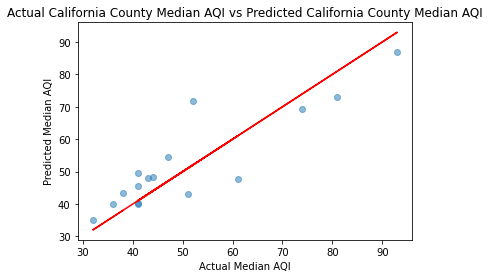

In [131]:
# Visualizing model accuracy

#add linear regression line to scatterplot 
plt.plot(y_test, y_test, color = 'r')
plt.scatter(y_test, y_predicted, alpha=0.5)
plt.xlabel("Actual Median AQI")
plt.ylabel("Predicted Median AQI")
plt.title("Actual California County Median AQI vs Predicted California County Median AQI")
print("r is: " + str(np.corrcoef(y_test, y_predicted)[0,1]))

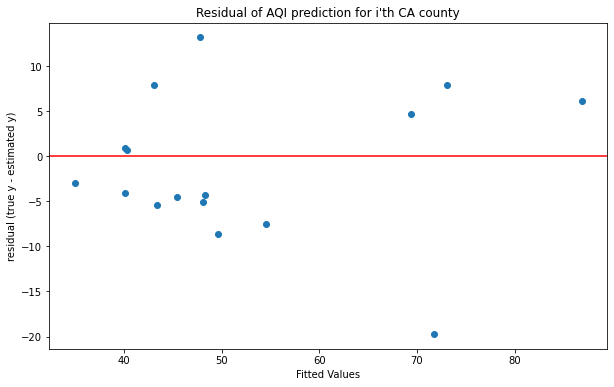

In [132]:
# Residual Plot
plt.figure(figsize=(10, 6))
fitted_values = model.predict(X_test)
plt.scatter(fitted_values, y_test - fitted_values)
plt.xlabel('Fitted Values')
plt.ylabel('residual (true y - estimated y)')
plt.title("Residual of AQI prediction for i'th CA county")
plt.axhline(y = 0, color='r');

In [133]:
# K folds cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold_validation = KFold(5) #5 splits, from slides: "Common choices for the tuning parameter K are between 5 and 10."
results_neg_rmse = cross_val_score(model, X_train, y_train, cv= kfold_validation, scoring = "neg_root_mean_squared_error")
mean_result_rmse = np.mean(results_neg_rmse)

results_r2 = cross_val_score(model, X_train, y_train, cv= kfold_validation, scoring = "r2")
r2_result = np.mean(results_r2)

print("Cross Validation Negated Root Mean Squared Error Score: " + str(mean_result_rmse))
print("Cross Validation r2 Score: " + str(r2_result))

Cross Validation Negated Root Mean Squared Error Score: -11.109334655215342
Cross Validation r2 Score: 0.0786720720418694


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

_Our baseline model is a multiple linear regression model trained on three features, Ozone Level PPM per County, Region and Number of Very Unhealthy Days to predict the median AQI of counties in California. "Region" is from an external dataset and gives U.S. Census classifications of California counties into regions, and the "Number of Very Unhealthy Days" comes from the initial AQI data and refers to the number of very unhealthy air quality days measured in that county during the year 2020. We used a 30/70 train-test split. Our model has pretty low variation, with an RMSE of 5.7627 (around 8.865% of the range of our data) and a rather high correlation coefficient R2 of 0.8839 (from the random seed we used for analysis). We used a k-fold cross validation of k=5 and received a low cross-validation R2 score of 0.2933. To improve our model, we want to make a couple adjustments. First, we want to make our model more complex and include demographic data, specifically looking at race. A nonzero correlation between race and AQI level would theoretically improve our model's predictive power, and we want to examine to what degree as well as the optimal number of racial demographics to include. We can also use this to support our hypothesis that the density of the African-American population in a geographic region is a predictor for the region's AQI. However, we are wary of overfitting, so in adding in more and more racial data, we want to watch out for a point where error begins to rise._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

In [134]:
# To determine a reasonable range for error we decided to calculate the range between min and max of Median AQI
error_range = max(california_aqis_and_race["Median AQI"]) - min(california_aqis_and_race["Median AQI"])
print("The difference between the max and mix value of our target is: " + str(error_range))

The difference between the max and mix value of our target is: 65


### Modification 1: Unhealthy Days

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# Model 1

# Features 
num_vars = ['Median Ozone PPM', "Unhealthy for Sensitive Groups Days"]
cat_vars = ["Region"]

# Defines design matrix X and target variables y
X = build_features(california_aqis_and_race, num_vars, cat_vars) #features (multiple linear regression on 2 features: Good Days)
y = california_aqis_and_race["Median AQI"].values

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 42) #splitting the data into test/train (30%)

model1 = LinearRegression()
model1.fit(X_train1, y_train1)
y_predicted1 = model1.predict(X_test1)
                             
# Error/Correlation Metrics

r2_score_1 = r2_score(y_test1, y_predicted1)
mse = mean_squared_error(y_test1, y_predicted1)
print("Model 1 R2 Score: " + str(r2_score_1))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(mse ** .5))

Model 1 R2 Score: 0.8839337435746579
Mean Squared Error: 33.209457619701006
Root Mean Squared Error: 5.762764754846497


In [136]:
kfold_validation = KFold(5) #5 splits, from slides: "Common choices for the tuning parameter K are between 5 and 10."
results_neg_rmse = cross_val_score(model1, X_train1, y_train1, cv= kfold_validation, scoring = "neg_root_mean_squared_error")
mean_result_rmse = np.mean(results_neg_rmse)

results_r2 = cross_val_score(model1, X_train1, y_train1, cv= kfold_validation, scoring = "r2")
r2_result = np.mean(results_r2)

print("Cross Validation Negated Root Mean Squared Error Score: " + str(mean_result_rmse))
print("Cross Validation r2 Score: " + str(r2_result))

Cross Validation Negated Root Mean Squared Error Score: -8.961237807872227
Cross Validation r2 Score: 0.29332819961372275


r is: 0.9593762933871013


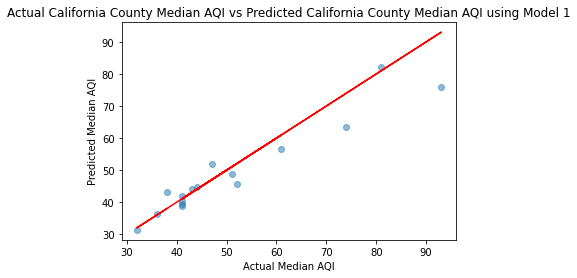

In [137]:
# Visualizing model accuracy
#add linear regression line to scatterplot 
plt.plot(y_test1, y_test1, color = 'r')
plt.scatter(y_test1, y_predicted1, alpha=0.5)
plt.xlabel("Actual Median AQI")
plt.ylabel("Predicted Median AQI")
plt.title("Actual California County Median AQI vs Predicted California County Median AQI using Model 1")
print("r is: " + str(np.corrcoef(y_test1, y_predicted1)[0,1]))


### Modification 2: Other Factors Related to Race To Choose Best Model

#### Model 2 (Additional Features to Model 1: Region and Unhealthy for Sensitive)

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# Model 2

# Features 
num_vars = ['Median Ozone PPM', "Black or African American alone", "Unhealthy for Sensitive Groups Days"]
cat_vars = ["Region"]

# Defines design matrix X and target variables y
X = build_features(california_aqis_and_race, num_vars, cat_vars) #features 
y = california_aqis_and_race["Median AQI"].values #targets

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.3, random_state = 42) #splitting the data into test/train (30%)

model2 = LinearRegression()
model2.fit(X_train2, y_train2)
y_predicted2 = model2.predict(X_test2)
                             
# Error/Correlation Metrics

r2_score_2 = r2_score(y_test2, y_predicted2)
mse = mean_squared_error(y_test2, y_predicted2)
print("Model 2 R2 Score: " + str(r2_score_2))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(mse ** .5))

Model 2 R2 Score: 0.8872024922209899
Mean Squared Error: 32.27418691326927
Root Mean Squared Error: 5.681037485641973


In [139]:
kfold_validation = KFold(5) #5 splits, from slides: "Common choices for the tuning parameter K are between 5 and 10."
results_neg_rmse = cross_val_score(model2, X_train2, y_train2, cv= kfold_validation, scoring = "neg_root_mean_squared_error")
mean_result_rmse = np.mean(results_neg_rmse)

results_r2 = cross_val_score(model2, X_train2, y_train2, cv= kfold_validation, scoring = "r2")
r2_result = np.mean(results_r2)

print("Cross Validation Negated Root Mean Squared Error Score: " + str(mean_result_rmse))
print("Cross Validation r2 Score: " + str(r2_result))

Cross Validation Negated Root Mean Squared Error Score: -7.703691632389868
Cross Validation r2 Score: 0.5128870698995398


#### Model 3 (Additional Features to Model 1: Region and Proportion of Caucasians)

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# Model 3

# Features 
num_vars = ['Median Ozone PPM', "Black or African American alone", "White alone", "Unhealthy for Sensitive Groups Days"]
cat_vars = ["Region"]

# Defines design matrix X and target variables y
X = build_features(california_aqis_and_race, num_vars, cat_vars) #features 
y = california_aqis_and_race["Median AQI"].values #targets

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.3, random_state = 42) #splitting the data into test/train (30%)

model3 = LinearRegression()
model3.fit(X_train3, y_train3)
y_predicted3 = model3.predict(X_test3)
                             
# Error/Correlation Metrics

r2_score_3 = r2_score(y_test3, y_predicted3)
mse = mean_squared_error(y_test3, y_predicted3)
print("Model 3 R2 Score: " + str(r2_score_3))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(mse ** .5))

Model 3 R2 Score: 0.8991358693338377
Mean Squared Error: 28.85974938685569
Root Mean Squared Error: 5.372127082158024


In [141]:
kfold_validation = KFold(5) #5 splits, from slides: "Common choices for the tuning parameter K are between 5 and 10."
results_neg_rmse = cross_val_score(model3, X_train3, y_train3, cv= kfold_validation, scoring = "neg_root_mean_squared_error")
mean_result_rmse = np.mean(results_neg_rmse)

results_r2 = cross_val_score(model3, X_train3, y_train3, cv= kfold_validation, scoring = "r2")
r2_result = np.mean(results_r2)

print("Cross Validation Negated Root Mean Squared Error Score: " + str(mean_result_rmse))
print("Cross Validation r2 Score: " + str(r2_result))

Cross Validation Negated Root Mean Squared Error Score: -7.964879409018662
Cross Validation r2 Score: 0.43685331701597774


#### Model 4 (Additional Features to Model 1: Region and Proportion of Caucasians and Proportion of American Indian/Alaska Natives)

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# Model 4

# Features 
num_vars = ['Median Ozone PPM', "Black or African American alone", "White alone", "Unhealthy for Sensitive Groups Days", "American Indian and Alaska Native alone"]
cat_vars = ["Region"]

# Defines design matrix X and target variables y
X = build_features(california_aqis_and_race, num_vars, cat_vars) #features 
y = california_aqis_and_race["Median AQI"].values #targets

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.3, random_state = 42) #splitting the data into test/train (30%)

model4 = LinearRegression()
model4.fit(X_train4, y_train4)
y_predicted4 = model4.predict(X_test4)
                             
# Error/Correlation Metrics

r2_score_4 = r2_score(y_test4, y_predicted4)
mse = mean_squared_error(y_test4, y_predicted4)
print("Model 4 R2 Score: " + str(r2_score_4))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(mse ** .5))

Model 4 R2 Score: 0.860821926365825
Mean Squared Error: 39.822326318578305
Root Mean Squared Error: 6.310493349856119


In [143]:
kfold_validation = KFold(5) #5 splits, from slides: "Common choices for the tuning parameter K are between 5 and 10."
results_neg_rmse = cross_val_score(model4, X_train4, y_train4, cv= kfold_validation, scoring = "neg_root_mean_squared_error")
mean_result_rmse = np.mean(results_neg_rmse)

results_r2 = cross_val_score(model4, X_train4, y_train4, cv= kfold_validation, scoring = "r2")
r2_result = np.mean(results_r2)

print("Cross Validation Negated Root Mean Squared Error Score: " + str(mean_result_rmse))
print("Cross Validation r2 Score: " + str(r2_result))

Cross Validation Negated Root Mean Squared Error Score: -8.235106763239681
Cross Validation r2 Score: 0.42742354015672934


1) Our first improvement was noticing that the feature Very Unhealthy Days could be related with wildfires and extreme edge cases rather than systemic racism. As such, we decided to change that feature from Very Unhealthy to Unhealthy for Sensitive Groups. In addition, we added a categorical Region feature to see if it helped improve the model.

2) We added additional racial data and compared several models to determine the optimal model via our cross validation scores and model r2 and RMSE

In the end we chose model 2 because it had the best Cross Validation scores while still having a very high R2 and low RMSE on the test data.

r is: 0.9530316679584072


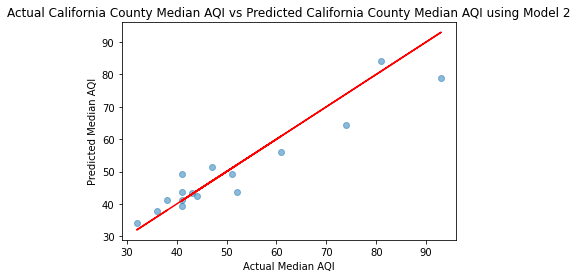

In [144]:
# We settled on Model 2 when looking at our cross validation error and r2 score

#add y=x to scatterplot 
plt.plot(y_test2, y_test1, color = 'r')
plt.scatter(y_test2, y_predicted2, alpha=0.5)
plt.xlabel("Actual Median AQI")
plt.ylabel("Predicted Median AQI")
plt.title("Actual California County Median AQI vs Predicted California County Median AQI using Model 2")
print("r is: " + str(np.corrcoef(y_test2, y_predicted2)[0,1]))

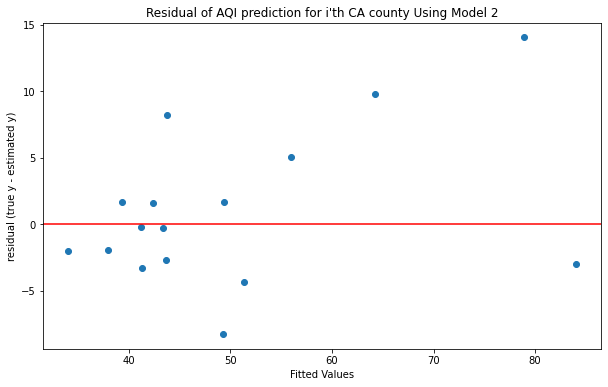

In [145]:
# Residual Plot
plt.figure(figsize=(10, 6))
fitted_values = model2.predict(X_test2)
plt.scatter(fitted_values, y_test2 - fitted_values)
plt.xlabel('Fitted Values')
plt.ylabel('residual (true y - estimated y)')
plt.title("Residual of AQI prediction for i'th CA county Using Model 2")
plt.axhline(y = 0, color='r');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->

_Our baseline model was a multiple linear regression model on two features, Region and the Number of Very Unhealthy Days (annual, based on air quality) in a region. Our improved model includes the African-American population density of each region as a fourth feature. Our correlation coefficient R2 of our new model was slightly higher than the baseline (0.8872 vs 0.8839) and our RMSE was slightly lower (5.6810 vs 5.7627), but our cross-validation R2 nearly doubled from 0.2933 in our baseline model to 0.5128 in our new model. We constructed multiple models in our analysis, each one adding in more racial data (first African-American, then White, then American-Indian). We settled on the model that had Median Ozone PPM, Region, Unhealthy for Sensitive Groups, and Black Proportion as features because our hypothesis pertains specifically to the predictive power of African-American population proportion. Additionally, due to the immense improvement in cross validation score, we fail to reject our hypothesis that African Americans have some predictive power in estimating AQI. However, it is important to note that while adding in only African-American population data improved our model across the board, RMSE began to rise with the addition of other racial demographic data. We believe this is because the addition of those factors caused overfitting in our model. Additionally, we have to be wary about our conclusion as we only utilized a total of 53 counties/data points, which means that our 70/30 train-test split led to a trade-off between test RMSE and R2 versus cross validation RMSE and R2._


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [146]:
grader.check_all()

q10b results: All test cases passed!

q10c results: All test cases passed!

q10d results: All test cases passed!

q10e results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q4a results: All test cases passed!

q4i results: All test cases passed!

q5a results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q8a results: All test cases passed!

q8b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [147]:
# Save your notebook first, then run this cell to export your submission.
grader.export()